# $$Can\ machines\ truly\ think—or\ even\ create?$$

This question lies at the heart of Generative AI. Unlike **traditional machine learning models** that focus on prediction or classification, generative models are designed to produce entirely new data. They don’t just analyze—they imagine and create.

At the core of many generative systems is a unique dual-network setup: the Generator and the Discriminator. Together, they form what's known as a Generative Adversarial Network (GAN).

* The Generator starts with random noise and learns to create data that mimics the real thing.

* The Discriminator tries to tell real data apart from the Generator’s fake data.

These two networks are trained together in a kind of digital tug-of-war—each trying to outsmart the other. Over time, this adversarial process improves both networks, resulting in a Generator capable of producing impressively realistic outputs.

In this notebook, we’ll dive into how to build a Generative AI model using GANs, step by step. But first, let’s understand what GANs really are.

## Introducing GANs :

Generative Adversarial Networks (GANs) consist of two competing neural networks:

* Generator: Learns to generate new, fake data from random noise.

* Discriminator: Learns to distinguish between real and fake data.

They play a zero-sum game:

* The Generator aims to fool the Discriminator.

* The Discriminator aims to catch the Generator’s fakes.

Now that we understand what GANs are and how they work, it's time to start building one from scratch.

We’ll use the MNIST dataset to train our model to generate handwritten digits.

### Import libraries :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Dropout
from keras.optimizers import Adam
import os

## Build generator network :

In [2]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(28 * 28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))

    return model

## Build a discriminator network :

In [3]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    return model

### Loss Plot :

In [4]:
def plot_losses(g_losses, d_losses):
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("GAN Losses over Epochs")
    plt.grid()
    plt.show()

### Image Saving  :

In [5]:
def save_images(epoch, generator, examples=25, dim=(5, 5), figsize=(5, 5)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0,1]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    os.makedirs("gan_images", exist_ok=True)
    plt.savefig(f"gan_images/generated_{epoch}.png")
    plt.close()

## Build Models :

In [6]:
optimizer = Adam(0.0002, 0.5)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Combined model (Generator + Discriminator)
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training the models :

In [7]:
def train_gan(epochs, batch_size=128, save_interval=1000):
    (X_train, _), _ = mnist.load_data()

    # Normalize to [-1, 1]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((batch_size, 1)) - np.random.random_sample((batch_size, 1)) * 0.1  # smooth real
        fake_labels = np.random.random_sample((batch_size, 1)) * 0.1  # noisy fake

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))  # Generator wants labels to be real
        g_loss = gan.train_on_batch(noise, valid_y)

        # Save losses
        g_losses.append(g_loss)
        d_losses.append(d_loss[0])

        # Print progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

        # Save image grid
        if epoch % save_interval == 0:
            save_images(epoch, generator)

    # Plot loss curves
    plot_losses(g_losses, d_losses)

## Start Training :

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 1.0627, acc.: 0.00] [G loss: 0.9141]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4

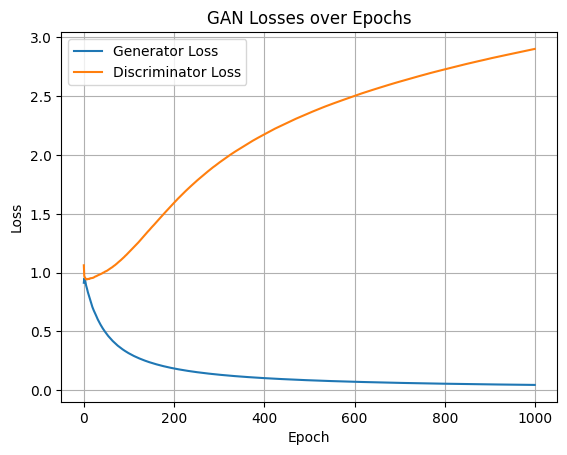

In [8]:
train_gan(epochs=1000, batch_size=128, save_interval=1000)

* The blue line (Generator Loss) is decreasing and stabilizing at a low value, which indicates that the generator is getting better at creating images that can fool the discriminator.

* The orange line (Discriminator Loss) is increasing, which means the discriminator is finding it harder to distinguish between real and fake images. This is expected behavior as the generator improves.